In [27]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch 
from torch.autograd import Variable 
from matplotlib import pyplot as plt
import torch.nn.functional as F
import time
from statistics import mean
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import scale
from sklearn import metrics

In [28]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [29]:
# Read in data from small csv to a dataframe
df1=pd.read_csv('weather_small.csv', sep=',')

# Reformat data in date/time column 
df1['Formatted Date'] =  pd.to_datetime(df1['Formatted Date'])

# Create a new column for year / month / hour
df1['Year'] = pd.DatetimeIndex(df1['Formatted Date']).year
df1['Month'] = pd.DatetimeIndex(df1['Formatted Date']).month
df1['Hour'] = pd.DatetimeIndex(df1['Formatted Date']).hour

# Encode month and hour for cyclical nature
df1 = encode(df1, 'Month', 13)
df1 = encode(df1, 'Hour', 23)
df1 = encode(df1, 'Wind Bearing (degrees)', 359)

# Remove original date/time column
df1=df1.drop(['Formatted Date'],axis=1)

# Convert columns to factors
df1['Summary'] = df1['Summary'].astype('category')
df1['Precip Type'] = df1['Precip Type'].astype('category')
df1['Daily Summary'] = df1['Daily Summary'].astype('category')

# Create a column stating whether its mostly cloudy / overcast or not in summary
df1['Heavy_Cloud'] = pd.np.where(df1.Summary.str.contains("Mostly Cloudy"), 1,
                    pd.np.where(df1.Summary.str.contains("Overcast"), 1,
                    pd.np.where(df1.Summary.str.contains("Foggy"), 1,0)))

# Convert to boolean and print count
df1['Heavy_Cloud']=df1['Heavy_Cloud'].astype('bool')

In [30]:
y = df1['Heavy_Cloud']
X=scale(df1[['Temperature (C)','Apparent Temperature (C)','Humidity','Wind Speed (km/h)','Month_cos','Visibility (km)']])
X = pd.DataFrame(data=X)

num = len(df1)
indices = list(range(num))
split = int(max(indices)*0.1)

test_idx = np.random.choice(indices, size=split, replace=False)

inter_idx = list(set(indices) - set(test_idx))

num = len(inter_idx)
indices = list(range(num))
split = int(max(indices)*0.22)

valid_idx = np.random.choice(inter_idx, size=split, replace=False)
train_idx = list(set(inter_idx) - set(valid_idx))

x_train = np.array(X.loc[train_idx,:], dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_train = np.array(y[train_idx], dtype=np.float32)
y_train = y_train.reshape(-1, 1)

x_valid = np.array(X.loc[valid_idx,:], dtype=np.float32)
x_valid = x_valid.reshape(-1, 1)

y_valid = np.array(y[valid_idx], dtype=np.float32)
y_valid = y_valid.reshape(-1, 1)

x_test = np.array(X.loc[test_idx,:], dtype=np.float32)
x_test = x_test.reshape(-1, 1)

y_test = np.array(y[test_idx], dtype=np.float32)
y_test = y_test.reshape(-1, 1)

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(df1),2),
                                                       round(len(y_valid)/len(df1),2),
                                                       round(len(y_test)/len(df1),2)))

train: 0.7% | validation: 0.2% | test 0.1%


In [31]:
x_train = Variable(torch.Tensor(x_train))
x_train=x_train.view(-1,6)
y_train = Variable(torch.Tensor(y_train))

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(6, 1) # 2 in and 1 out
        
    def forward(self, x):
        y_pred = F.sigmoid(self.linear(x))
        return y_pred
    
# Our model    
model = Model()

num_epochs=10000
criterion = torch.nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
start_time = time.clock()
for epoch in range(num_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_train)
    
    # Compute and print loss
    loss = criterion(y_pred, y_train)
    # print(epoch, loss.data[0])
    
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    # print ('Epoch: [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, loss.data[0]))
print (time.clock() - start_time, "seconds")

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


19.607640000000004 seconds


In [32]:
x_valid = Variable(torch.Tensor(x_valid))
x_valid=x_valid.view(-1,6)
predictions = model(x_valid)

predictions=predictions.detach().numpy()
predictions=np.rint(predictions)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


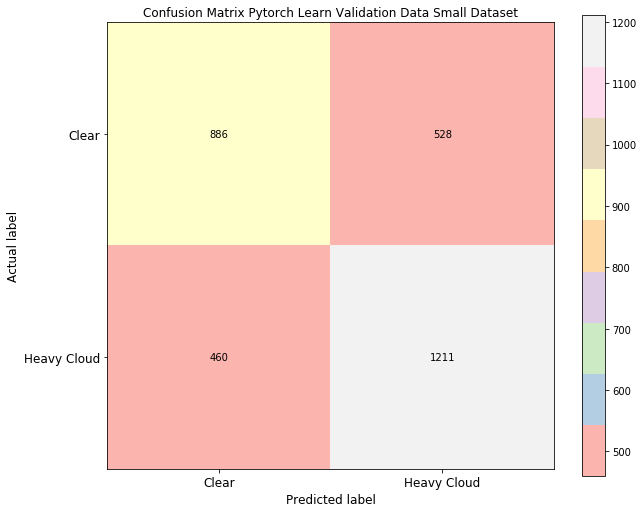

In [33]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_valid, predictions)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix Pytorch Learn Validation Data Small Dataset', size = 12)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.yticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cm.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm[x][y]), xy=(y, x), 
  horizontalalignment='center',
  verticalalignment='center')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
plt.savefig('Logistic_Regression_Validation_Confusion_Small_PT.png',pdi=600)

In [34]:
accuracy=sum(predictions==y_valid)/len(predictions)

ERR=1-accuracy
Recall = (cm[0,0])/(np.sum(cm,axis=1)[0])
FPR=(cm[1,0])/(np.sum(cm,axis=1)[1])
Specificity=1-FPR
FNR=1-Recall

print('Score of validation model: ',accuracy)
print('Error rate of validation model: ',ERR)
print('Recall / TPR of validation model: ',Recall)
print('FNR of validation model: ',FNR)
print('Specificity / TNR of validation model: ',Specificity)
print('FPR of validation model: ',FPR)

Score of validation model:  [0.67974068]
Error rate of validation model:  [0.32025932]
Recall / TPR of validation model:  0.6265912305516266
FNR of validation model:  0.3734087694483734
Specificity / TNR of validation model:  0.7247157390783961
FPR of validation model:  0.27528426092160385


AUC of validation model 0.6756534848150113


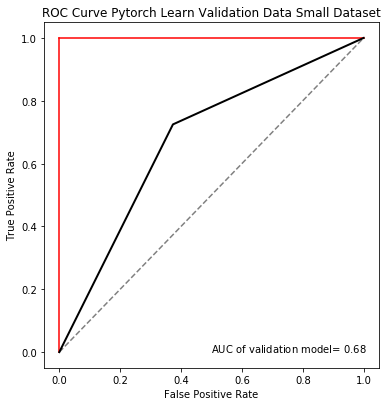

In [35]:
### calculate ROC Score
print("AUC of validation model",roc_auc_score(y_valid, predictions))
fpr, tpr, _ = metrics.roc_curve(y_valid, predictions)

fig, ax1=plt.subplots(figsize=(6,6))
x1 = [0, 0]
x2 = [0,1]
y1=[0,1]
y2=[1,1]
ax1.plot(x1, y1, 'red')
ax1.plot(x2, y2, 'red')
ax1.plot(x2, y1, 'grey',linestyle='--')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Pytorch Learn Validation Data Small Dataset')
ax1.plot(fpr,tpr,color='Black',linewidth=2,label='ROC Curve')

textstr = 'AUC of validation model= $%.2f$'%(roc_auc_score(y_valid, predictions))
ax1.text(0.5,0,textstr)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
fig.savefig('Logistic_Regression_Validation_ROC_Small_PT.png',pdi=600)

In [36]:
x_test = Variable(torch.Tensor(x_test))
x_test=x_test.view(-1,6)
predictions_test = model(x_test)

predictions_test=predictions_test.detach().numpy()
predictions_test=np.rint(predictions_test)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


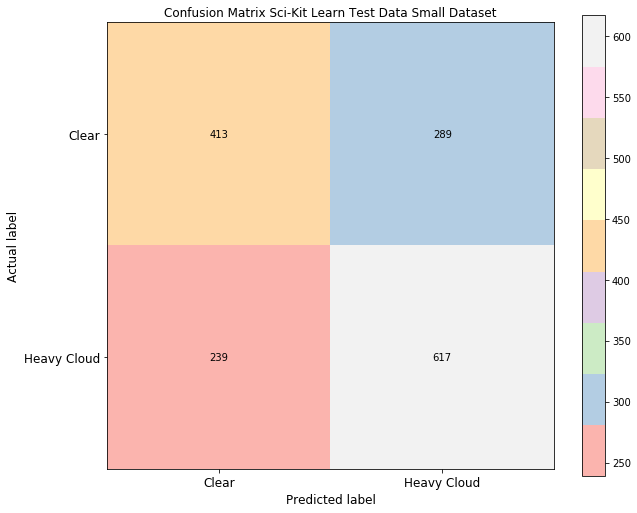

In [37]:
# Confusion Matrix
cm2 = metrics.confusion_matrix(y_test, predictions_test)
plt.figure(figsize=(10,8))
plt.imshow(cm2, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix Sci-Kit Learn Test Data Small Dataset', size = 12)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.yticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cm2.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm2[x][y]), xy=(y, x), 
  horizontalalignment='center',
  verticalalignment='center')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
plt.savefig('Logistic_Regression_Test_Confusion_Small_PT.png',pdi=600)

In [38]:
accuracy=sum(predictions_test==y_test)/len(predictions_test)
ERR=1-accuracy

FPR=(cm2[1,0])/(np.sum(cm2,axis=1)[1])
Specificity=1-FPR
Recall = (cm2[0,0])/(np.sum(cm2,axis=1)[0])
FNR=1-Recall

print('Score of test model: ',accuracy)
print('Error rate of test model: ',ERR)
print('Recall / TPR of test model: ',Recall)
print('FNR of test model: ',FNR)
print('Specificity / TNR of test model: ',Specificity)
print('FPR of test model: ',FPR)

Score of test model:  [0.66110398]
Error rate of test model:  [0.33889602]
Recall / TPR of test model:  0.5883190883190883
FNR of test model:  0.4116809116809117
Specificity / TNR of test model:  0.7207943925233644
FPR of test model:  0.27920560747663553


AUC of validation model 0.6545567404212265


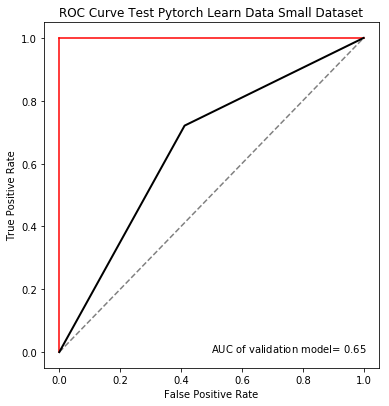

In [39]:
### calculate ROC Score
print("AUC of validation model",roc_auc_score(y_test, predictions_test))
fpr, tpr, _ = metrics.roc_curve(y_test, predictions_test)

fig, ax1=plt.subplots(figsize=(6,6))
x1 = [0, 0]
x2 = [0,1]
y1=[0,1]
y2=[1,1]
ax1.plot(x1, y1, 'red')
ax1.plot(x2, y2, 'red')
ax1.plot(x2, y1, 'grey',linestyle='--')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Test Pytorch Learn Data Small Dataset')
ax1.plot(fpr,tpr,color='Black',linewidth=2,label='ROC Curve')

textstr = 'AUC of validation model= $%.2f$'%(roc_auc_score(y_test, predictions_test))
ax1.text(0.5,0,textstr)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
fig.savefig('Logistic_Regression_Test_ROC_Small_PT.png',pdi=600)